# Importing Libraries

In [1]:
import numpy as np
import random
import gym
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

# Taxi-v3 Environment

In [2]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
state = env.reset()
# 25 taxi positions x 5 possible passenger locations x 4 destination location = 500 states

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Options

In [5]:
# 0: South, 1: North, 2: East, 3: West
# Deterministic policy which enables the agent to get goal R
R_Option_Policy = np.array([[1,3,0,0,0],
                         [1,3,0,0,0],
                         [1,3,3,3,3],
                         [1,1,1,1,1],
                         [1,1,1,1,1]])

# Deterministic policy which enables the agent to get goal G
G_Option_Policy = np.array([[0,0,2,2,1],
                         [0,0,2,2,1],
                         [2,2,2,1,1],
                         [1,2,1,1,1],
                         [1,2,1,1,1]])

# Deterministic policy which enables the agent to get goal Y
Y_Option_Policy = np.array([[0,3,0,0,0],
                         [0,3,0,0,0],
                         [0,3,3,3,3],
                         [0,1,1,1,3],
                         [0,1,3,1,3]])

# Deterministic policy which enables the agent to get goal B
B_Option_Policy = np.array([[0,0,0,0,3],
                         [0,0,0,0,3],
                         [2,2,2,0,3],
                         [1,1,1,0,3],
                         [1,1,1,0,3]])

In [3]:
'''
Primitive options are special cases of options which last exactly one step.
Primitive options are South, North, East, West, Pick, Drop.
Rest of the options defined are multi-step i.e., temporally extended.
Temporally extended options are Opt_R, Opt_G, Opt_Y, Opt_B

These options correspond to [0,1,2,3,4,5,6,7,8,9] respectively.
'''

default_options = ["South", "North", "East", "West", "Pick", "Drop",
           "Opt_R", "Opt_G", "Opt_Y", "Opt_B"]

In [6]:
def Default_Multistep_Option(option, state, environment, gamma):
    opt_done = False
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)}
    option_policy_mapping = {6: R_Option_Policy, 7: G_Option_Policy, 8: Y_Option_Policy, 9: B_Option_Policy}
    cumulative_reward = 0
    timestep_count = 0
    while not opt_done:
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        action = option_policy_mapping[option][taxi_row][taxi_col]
        next_state, reward, done, _ = environment.step(action)
        timestep_count += 1
        cumulative_reward += (gamma**(timestep_count-1))*reward
        state = next_state
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        if (taxi_row, taxi_col) == goal_locations[option]:
            opt_done = True

    return state, cumulative_reward, timestep_count, done

In [9]:
def Epsilon_Greedy_Policy(Q_values, epsilon, options, state):
    rand = np.random.random()
    if rand < epsilon:
        return np.random.randint(0, len(options))
    else:
        return np.argmax(Q_values[state])

In [10]:
def Execute_opt(option, state, environment):
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)}
    taxi_row, taxi_col, _, _ = list(environment.decode(state))
    if (taxi_row, taxi_col) == goal_locations[option]:
        return False
    else:
        return True

# SMDP Q-Learning

In [17]:
def SMDP_QL(num_episodes, alpha, gamma, epsilon, options, multistep_opt_config):

    environment = gym.make('Taxi-v3')
    Q_values = np.zeros((environment.observation_space.n, len(options)))
    episode_reward_list = []

    for ep in range(num_episodes):

        state_tuple = environment.reset()
        state = state_tuple
        done = False
        episode_reward = 0

        while not done:

            # Choose option using policy over options
            option = Epsilon_Greedy_Policy(Q_values, epsilon, options, state)


            if option < 6:
                next_state, reward, done, _ = environment.step(option)
                Q_values[state, option] += alpha*(reward + gamma*max(Q_values[next_state,:] -
                                                                     Q_values[state, option]))
                state = next_state
                episode_reward += reward


            else:
                execute_option = Execute_opt(option, state, environment)
                if execute_option:
                    next_state, cumulative_reward, timesteps_elapsed, done = multistep_opt_config(option, state, environment, gamma) # r(s,o) is cumulative reward for multi-step options
                    Q_values[state, option] += alpha*(cumulative_reward + (gamma**timesteps_elapsed)*(max(Q_values[next_state,:])-
                                                                                                      Q_values[state, option]))
                    state = next_state
                    episode_reward += cumulative_reward
                else:
                    state = next_state
                    done = False

        episode_reward_list.append(episode_reward)

    return episode_reward_list, Q_values

In [20]:
# Run SMDP Q-Learning

num_episodes = 4000
gamma = 0.9
epsilon = 0.01
alpha = 0.3

SMDP_episode_rewards, SMDP_Q_values = SMDP_QL(num_episodes=num_episodes, alpha=alpha, gamma=gamma,
                                                   epsilon=epsilon, options=default_options, multistep_opt_config = Default_Multistep_Option)

[[-1.31920734 -0.22904845 -1.44858564 ... -5.19156973 -2.25614327
  -4.16547206]
 [-1.20479933 -1.09755055 -1.43497284 ... -8.20464249 -3.88956583
  -7.74822848]
 [-0.67887    -0.67887     2.4193472  ... -1.70859837 -0.43396849
  -1.5651093 ]
 ...
 [-0.3        -0.3        -0.3        ...  0.          0.
   0.        ]
 [-0.3        -0.3        -0.3        ...  0.          0.
   0.        ]
 [-0.3        -0.3        -0.3        ...  1.97726667  0.
   0.        ]]


Text(0.5, 0, 'Episodes')

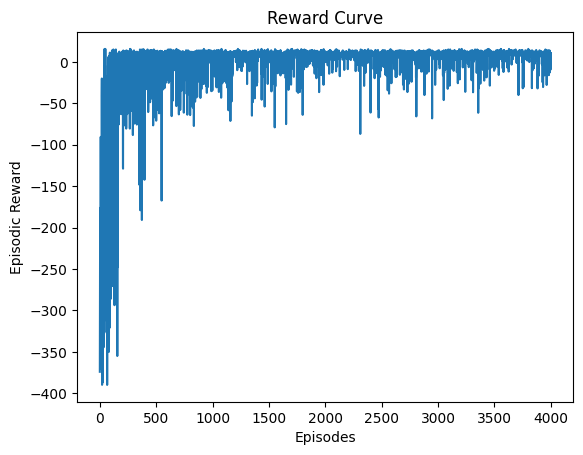

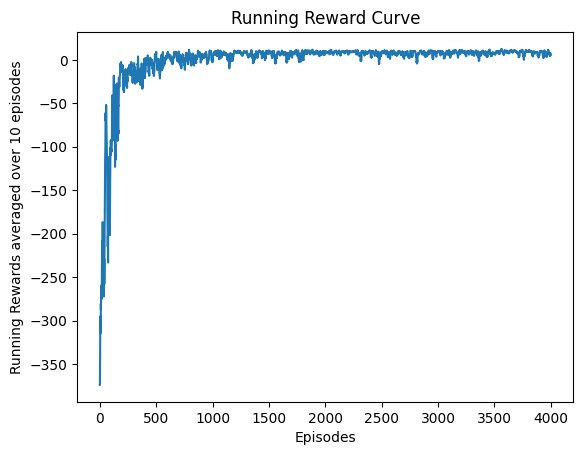

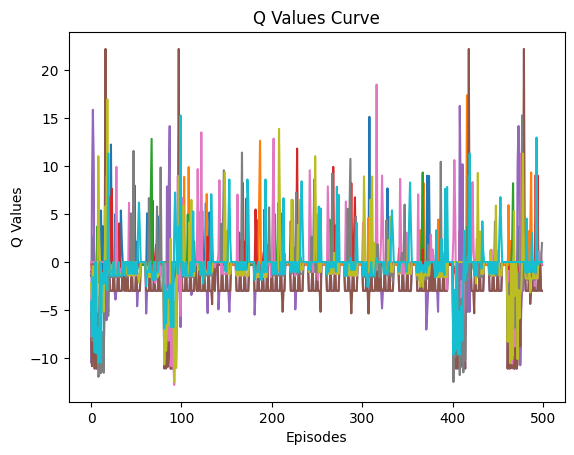

In [21]:
# Plot reward curve
plt.figure()
plt.plot(SMDP_episode_rewards)
plt.ylabel('Episodic Reward')
plt.title('Reward Curve')
plt.xlabel('Episodes')

SMDP_running_rewards = []
SMDP_running_rewards.append(SMDP_episode_rewards[0])
for i in range(1,num_episodes):
    SMDP_running_rewards.append(np.mean(SMDP_episode_rewards[max(0,i-10):i]))

plt.figure()
plt.plot(SMDP_running_rewards)
plt.ylabel('Running Rewards averaged over 10 episodes')
plt.title('Running Reward Curve')
plt.xlabel('Episodes')

print(SMDP_Q_values)
plt.figure()
plt.plot(SMDP_Q_values)
plt.ylabel('Q Values')
plt.title('Q Values Curve')
plt.xlabel('Episodes')